# Neural Networks - how to get a decent architecture?

## _Important_ if you let this run on Colab switch on the GPU option, because otherwise this part will take quite some time

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [4]:
import pandas as pd
print(pd.__version__)

0.23.3


In [5]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.9.0


In [7]:
# let's see what compute devices we have available, hopefully a GPU 
sess = tf.Session()
devices = sess.list_devices()
for d in devices:
    print(d.name)

/job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:GPU:0


In [8]:
# a small sane check, does tf seem to work ok?
hello = tf.constant('Hello TF!')
print(sess.run(hello))

b'Hello TF!'


## Loading and preparing our data set for classification

In [9]:
!curl -O https://raw.githubusercontent.com/DJCordhose/ai/master/notebooks/manning/data/insurance-customers-1500.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 26798  100 26798    0     0  90228      0 --:--:-- --:--:-- --:--:-- 90228


In [14]:
df = pd.read_csv('./insurance-customers-1500.csv', sep=';')
y=df['group']
df.drop('group', axis='columns', inplace=True)
X = df.as_matrix()

In [15]:
df.head()

,max speed,age,thousand miles per year
0,98.0,44.0,25.0
1,118.0,54.0,24.0
2,111.0,26.0,34.0
3,97.0,25.0,10.0
4,114.0,38.0,22.0


In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [19]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((900, 3), (900,), (600, 3), (600,))

In [20]:
# ignore this, it is just technical code to plot decision boundaries
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/

from matplotlib.colors import ListedColormap

cmap_print = ListedColormap(['#AA8888', '#004000', '#FFFFDD'])
cmap_bold = ListedColormap(['#AA4444', '#006000', '#EEEE44'])
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#FFFFDD'])
font_size=25
title_font_size=40

def meshGrid(x_data, y_data):
    h = 1  # step size in the mesh
    x_min, x_max = x_data.min() - 1, x_data.max() + 1
    y_min, y_max = y_data.min() - 1, y_data.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return (xx,yy)
    
def plot_prediction(clf, x_data, y_data, x_label, y_label, ground_truth, title="", 
                          mesh=True, fixed=None, fname=None, print=False):
    xx,yy = meshGrid(x_data, y_data)
    fig, ax = plt.subplots(figsize=(20,10))

    if clf and mesh:
        grid_X = np.array(np.c_[yy.ravel(), xx.ravel()])
        if fixed:
            fill_values = np.full((len(grid_X), 1), fixed)
            grid_X = np.append(grid_X, fill_values, axis=1)
        Z = clf.predict(grid_X)
        Z = np.argmax(Z, axis=1)
        Z = Z.reshape(xx.shape)
        ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
        
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    if print:
        ax.scatter(x_data, y_data, c=ground_truth, cmap=cmap_print, s=200, marker='o', edgecolors='k')
    else:
        ax.scatter(x_data, y_data, c=ground_truth, cmap=cmap_bold, s=100, marker='o', edgecolors='k')
        
    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(title, fontsize=title_font_size)
    if fname:
        fig.savefig('figures/'+fname)

In [24]:
X_train_2_dim = X_train[:, :2]
X_test_2_dim = X_test[:, :2]

num_categories = 3

### We have several means of regularization for neural networks and we use a combination of them as described below.
- reduce capacity of model
- dropout
- batch normalization
- change activation to relu for faster training
- reduce amount of training cycles

### An experimental approach:
- keep adding regularization to make test and train scores come closer to each other
- this will come at the cost of train scores going down
- if both values start going down you have one too far
- each experiment takes some time
- for larger datasets and more complex models some people start by overfitting on a subsample of the data (because it trains much faster)
  - then you can be sure you have an architecture that at least has the capacity to solve the problem
  - then keep adding regularizations
  - eventually try using the complete data

In [71]:
# https://stackoverflow.com/questions/34716454/where-do-i-call-the-batchnormalization-function-in-keras

dropout = 0.6
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(100, name='hidden1', input_dim=2))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(dropout))

model.add(tf.keras.layers.Dense(100, name='hidden2'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(dropout))

model.add(tf.keras.layers.Dense(num_categories, name='softmax', activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 100)               300       
_________________________________________________________________
batch_normalization_18 (Batc (None, 100)               400       
_________________________________________________________________
activation_18 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 100)               0         
_________________________________________________________________
hidden2 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_19 (Batc (None, 100)               400       
_________________________________________________________________
activation_19 (Activation)   (None, 100)               0         
__________

In [72]:
# only if you are running this locally
# !rm -rf ./tf_log
# https://keras.io/callbacks/#tensorboard
# tb_callback = tf.keras.callbacks.TensorBoard(log_dir='./tf_log')
# To start tensorboard
# tensorboard --logdir=./tf_log
# open http://localhost:6006

In [73]:
BATCH_SIZE=1000
EPOCHS = 2000

# %time model.fit(X_train_2_dim, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[tb_callback])
%time model.fit(X_train_2_dim, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

Train on 720 samples, validate on 180 samples
Epoch 1/2000
720/720 [==============================] - 2s 2ms/step - loss: 1.7299 - acc: 0.3361 - val_loss: 7.7084 - val_acc: 0.3389
Epoch 2/2000
720/720 [==============================] - 0s 17us/step - loss: 1.6638 - acc: 0.3458 - val_loss: 5.7952 - val_acc: 0.3389
Epoch 3/2000
720/720 [==============================] - 0s 15us/step - loss: 1.6117 - acc: 0.3556 - val_loss: 4.1244 - val_acc: 0.3389
Epoch 4/2000
720/720 [==============================] - 0s 17us/step - loss: 1.6132 - acc: 0.3444 - val_loss: 2.8882 - val_acc: 0.3389
Epoch 5/2000
720/720 [==============================] - 0s 17us/step - loss: 1.5742 - acc: 0.3639 - val_loss: 3.5112 - val_acc: 0.3278
Epoch 6/2000
720/720 [==============================] - 0s 24us/step - loss: 1.6130 - acc: 0.3125 - val_loss: 5.2281 - val_acc: 0.3278
Epoch 7/2000
720/720 [==============================] - 0s 22us/step - loss: 1.3990 - acc: 0.3903 - val_loss: 6.7276 - val_acc: 0.3278
Epoch 8/20

Epoch 61/2000
720/720 [==============================] - 0s 18us/step - loss: 1.0253 - acc: 0.5472 - val_loss: 3.2971 - val_acc: 0.3389
Epoch 62/2000
720/720 [==============================] - 0s 17us/step - loss: 0.9847 - acc: 0.5722 - val_loss: 3.2501 - val_acc: 0.3444
Epoch 63/2000
720/720 [==============================] - 0s 17us/step - loss: 0.9981 - acc: 0.5569 - val_loss: 3.2144 - val_acc: 0.3278
Epoch 64/2000
720/720 [==============================] - 0s 21us/step - loss: 0.9726 - acc: 0.5750 - val_loss: 3.1750 - val_acc: 0.3444
Epoch 65/2000
720/720 [==============================] - 0s 22us/step - loss: 0.9842 - acc: 0.5736 - val_loss: 3.1411 - val_acc: 0.3333
Epoch 66/2000
720/720 [==============================] - 0s 36us/step - loss: 0.9745 - acc: 0.5417 - val_loss: 3.1049 - val_acc: 0.3333
Epoch 67/2000
720/720 [==============================] - 0s 18us/step - loss: 1.0444 - acc: 0.5500 - val_loss: 3.0688 - val_acc: 0.3333
Epoch 68/2000
720/720 [=========================

720/720 [==============================] - 0s 22us/step - loss: 0.9232 - acc: 0.5847 - val_loss: 1.5829 - val_acc: 0.3944
Epoch 122/2000
720/720 [==============================] - 0s 35us/step - loss: 0.8717 - acc: 0.6069 - val_loss: 1.5720 - val_acc: 0.3944
Epoch 123/2000
720/720 [==============================] - 0s 19us/step - loss: 0.8785 - acc: 0.6042 - val_loss: 1.5588 - val_acc: 0.3944
Epoch 124/2000
720/720 [==============================] - 0s 17us/step - loss: 0.8689 - acc: 0.6069 - val_loss: 1.5443 - val_acc: 0.3944
Epoch 125/2000
720/720 [==============================] - 0s 0us/step - loss: 0.8759 - acc: 0.6208 - val_loss: 1.5313 - val_acc: 0.4000
Epoch 126/2000
720/720 [==============================] - 0s 0us/step - loss: 0.8939 - acc: 0.5819 - val_loss: 1.5181 - val_acc: 0.4000
Epoch 127/2000
720/720 [==============================] - 0s 38us/step - loss: 0.8979 - acc: 0.6042 - val_loss: 1.5033 - val_acc: 0.4000
Epoch 128/2000
720/720 [==============================] - 

Epoch 181/2000
720/720 [==============================] - 0s 33us/step - loss: 0.8490 - acc: 0.6111 - val_loss: 1.0956 - val_acc: 0.5000
Epoch 182/2000
720/720 [==============================] - 0s 21us/step - loss: 0.8490 - acc: 0.6208 - val_loss: 1.0911 - val_acc: 0.5000
Epoch 183/2000
720/720 [==============================] - 0s 19us/step - loss: 0.8116 - acc: 0.6319 - val_loss: 1.0850 - val_acc: 0.5000
Epoch 184/2000
720/720 [==============================] - 0s 17us/step - loss: 0.8502 - acc: 0.6333 - val_loss: 1.0793 - val_acc: 0.5000
Epoch 185/2000
720/720 [==============================] - 0s 18us/step - loss: 0.8509 - acc: 0.6306 - val_loss: 1.0737 - val_acc: 0.5111
Epoch 186/2000
720/720 [==============================] - 0s 18us/step - loss: 0.8357 - acc: 0.6556 - val_loss: 1.0669 - val_acc: 0.5222
Epoch 187/2000
720/720 [==============================] - 0s 18us/step - loss: 0.8257 - acc: 0.6278 - val_loss: 1.0611 - val_acc: 0.5222
Epoch 188/2000
720/720 [=================

Epoch 241/2000
720/720 [==============================] - 0s 22us/step - loss: 0.8207 - acc: 0.6403 - val_loss: 0.8866 - val_acc: 0.6278
Epoch 242/2000
720/720 [==============================] - 0s 34us/step - loss: 0.8497 - acc: 0.6264 - val_loss: 0.8862 - val_acc: 0.6333
Epoch 243/2000
720/720 [==============================] - 0s 18us/step - loss: 0.8364 - acc: 0.6486 - val_loss: 0.8854 - val_acc: 0.6278
Epoch 244/2000
720/720 [==============================] - 0s 17us/step - loss: 0.8177 - acc: 0.6347 - val_loss: 0.8841 - val_acc: 0.6333
Epoch 245/2000
720/720 [==============================] - 0s 19us/step - loss: 0.8097 - acc: 0.6528 - val_loss: 0.8829 - val_acc: 0.6333
Epoch 246/2000
720/720 [==============================] - 0s 18us/step - loss: 0.8318 - acc: 0.6569 - val_loss: 0.8812 - val_acc: 0.6333
Epoch 247/2000
720/720 [==============================] - 0s 33us/step - loss: 0.8193 - acc: 0.6361 - val_loss: 0.8795 - val_acc: 0.6333
Epoch 248/2000
720/720 [=================

Epoch 301/2000
720/720 [==============================] - 0s 19us/step - loss: 0.8188 - acc: 0.6306 - val_loss: 0.8013 - val_acc: 0.6500
Epoch 302/2000
720/720 [==============================] - 0s 18us/step - loss: 0.8259 - acc: 0.6528 - val_loss: 0.8009 - val_acc: 0.6500
Epoch 303/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7950 - acc: 0.6472 - val_loss: 0.8004 - val_acc: 0.6500
Epoch 304/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7945 - acc: 0.6639 - val_loss: 0.7997 - val_acc: 0.6500
Epoch 305/2000
720/720 [==============================] - 0s 18us/step - loss: 0.8147 - acc: 0.6542 - val_loss: 0.7992 - val_acc: 0.6500
Epoch 306/2000
720/720 [==============================] - 0s 17us/step - loss: 0.7993 - acc: 0.6792 - val_loss: 0.7982 - val_acc: 0.6500
Epoch 307/2000
720/720 [==============================] - 0s 18us/step - loss: 0.8030 - acc: 0.6611 - val_loss: 0.7971 - val_acc: 0.6500
Epoch 308/2000
720/720 [=================

Epoch 361/2000
720/720 [==============================] - 0s 28us/step - loss: 0.8003 - acc: 0.6500 - val_loss: 0.7619 - val_acc: 0.6722
Epoch 362/2000
720/720 [==============================] - 0s 18us/step - loss: 0.8182 - acc: 0.6361 - val_loss: 0.7614 - val_acc: 0.6722
Epoch 363/2000
720/720 [==============================] - 0s 19us/step - loss: 0.8107 - acc: 0.6639 - val_loss: 0.7610 - val_acc: 0.6722
Epoch 364/2000
720/720 [==============================] - 0s 18us/step - loss: 0.8242 - acc: 0.6611 - val_loss: 0.7607 - val_acc: 0.6722
Epoch 365/2000
720/720 [==============================] - 0s 32us/step - loss: 0.8294 - acc: 0.6375 - val_loss: 0.7605 - val_acc: 0.6722
Epoch 366/2000
720/720 [==============================] - 0s 17us/step - loss: 0.7638 - acc: 0.6847 - val_loss: 0.7603 - val_acc: 0.6722
Epoch 367/2000
720/720 [==============================] - 0s 22us/step - loss: 0.8215 - acc: 0.6542 - val_loss: 0.7604 - val_acc: 0.6722
Epoch 368/2000
720/720 [=================

Epoch 421/2000
720/720 [==============================] - 0s 17us/step - loss: 0.7774 - acc: 0.6694 - val_loss: 0.7533 - val_acc: 0.6611
Epoch 422/2000
720/720 [==============================] - 0s 17us/step - loss: 0.8291 - acc: 0.6431 - val_loss: 0.7530 - val_acc: 0.6556
Epoch 423/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7831 - acc: 0.6819 - val_loss: 0.7527 - val_acc: 0.6556
Epoch 424/2000
720/720 [==============================] - 0s 18us/step - loss: 0.8049 - acc: 0.6639 - val_loss: 0.7524 - val_acc: 0.6556
Epoch 425/2000
720/720 [==============================] - 0s 28us/step - loss: 0.8028 - acc: 0.6639 - val_loss: 0.7522 - val_acc: 0.6556
Epoch 426/2000
720/720 [==============================] - 0s 32us/step - loss: 0.7829 - acc: 0.6528 - val_loss: 0.7523 - val_acc: 0.6556
Epoch 427/2000
720/720 [==============================] - 0s 43us/step - loss: 0.8065 - acc: 0.6722 - val_loss: 0.7523 - val_acc: 0.6556
Epoch 428/2000
720/720 [=================

Epoch 481/2000
720/720 [==============================] - 0s 31us/step - loss: 0.7905 - acc: 0.6806 - val_loss: 0.7502 - val_acc: 0.6667
Epoch 482/2000
720/720 [==============================] - 0s 21us/step - loss: 0.8136 - acc: 0.6597 - val_loss: 0.7503 - val_acc: 0.6722
Epoch 483/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7885 - acc: 0.6736 - val_loss: 0.7504 - val_acc: 0.6722
Epoch 484/2000
720/720 [==============================] - 0s 21us/step - loss: 0.7924 - acc: 0.6611 - val_loss: 0.7504 - val_acc: 0.6722
Epoch 485/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7917 - acc: 0.6583 - val_loss: 0.7503 - val_acc: 0.6722
Epoch 486/2000
720/720 [==============================] - 0s 18us/step - loss: 0.8004 - acc: 0.6639 - val_loss: 0.7503 - val_acc: 0.6667
Epoch 487/2000
720/720 [==============================] - 0s 21us/step - loss: 0.7873 - acc: 0.6597 - val_loss: 0.7507 - val_acc: 0.6667
Epoch 488/2000
720/720 [=================

Epoch 541/2000
720/720 [==============================] - 0s 18us/step - loss: 0.8149 - acc: 0.6556 - val_loss: 0.7416 - val_acc: 0.6833
Epoch 542/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7584 - acc: 0.6750 - val_loss: 0.7409 - val_acc: 0.6833
Epoch 543/2000
720/720 [==============================] - 0s 21us/step - loss: 0.7716 - acc: 0.6778 - val_loss: 0.7402 - val_acc: 0.6833
Epoch 544/2000
720/720 [==============================] - 0s 21us/step - loss: 0.7824 - acc: 0.6611 - val_loss: 0.7398 - val_acc: 0.6833
Epoch 545/2000
720/720 [==============================] - 0s 28us/step - loss: 0.7840 - acc: 0.6597 - val_loss: 0.7398 - val_acc: 0.6833
Epoch 546/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7863 - acc: 0.6750 - val_loss: 0.7400 - val_acc: 0.6833
Epoch 547/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7855 - acc: 0.6819 - val_loss: 0.7402 - val_acc: 0.6833
Epoch 548/2000
720/720 [=================

Epoch 601/2000
720/720 [==============================] - 0s 26us/step - loss: 0.7651 - acc: 0.6750 - val_loss: 0.7448 - val_acc: 0.6500
Epoch 602/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7602 - acc: 0.6889 - val_loss: 0.7449 - val_acc: 0.6500
Epoch 603/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7895 - acc: 0.6625 - val_loss: 0.7449 - val_acc: 0.6556
Epoch 604/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7795 - acc: 0.6625 - val_loss: 0.7446 - val_acc: 0.6556
Epoch 605/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7792 - acc: 0.6597 - val_loss: 0.7441 - val_acc: 0.6500
Epoch 606/2000
720/720 [==============================] - 0s 17us/step - loss: 0.7906 - acc: 0.6722 - val_loss: 0.7434 - val_acc: 0.6500
Epoch 607/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7642 - acc: 0.7028 - val_loss: 0.7428 - val_acc: 0.6500
Epoch 608/2000
720/720 [=================

Epoch 661/2000
720/720 [==============================] - 0s 43us/step - loss: 0.7762 - acc: 0.6681 - val_loss: 0.7380 - val_acc: 0.6611
Epoch 662/2000
720/720 [==============================] - 0s 43us/step - loss: 0.7855 - acc: 0.6806 - val_loss: 0.7383 - val_acc: 0.6611
Epoch 663/2000
720/720 [==============================] - 0s 49us/step - loss: 0.7827 - acc: 0.6750 - val_loss: 0.7385 - val_acc: 0.6611
Epoch 664/2000
720/720 [==============================] - 0s 39us/step - loss: 0.7633 - acc: 0.6819 - val_loss: 0.7387 - val_acc: 0.6611
Epoch 665/2000
720/720 [==============================] - 0s 49us/step - loss: 0.7771 - acc: 0.6694 - val_loss: 0.7389 - val_acc: 0.6611
Epoch 666/2000
720/720 [==============================] - 0s 33us/step - loss: 0.7657 - acc: 0.6736 - val_loss: 0.7392 - val_acc: 0.6556
Epoch 667/2000
720/720 [==============================] - 0s 21us/step - loss: 0.7868 - acc: 0.6778 - val_loss: 0.7395 - val_acc: 0.6556
Epoch 668/2000
720/720 [=================

Epoch 721/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7874 - acc: 0.6639 - val_loss: 0.7356 - val_acc: 0.6667
Epoch 722/2000
720/720 [==============================] - 0s 21us/step - loss: 0.7680 - acc: 0.6722 - val_loss: 0.7364 - val_acc: 0.6667
Epoch 723/2000
720/720 [==============================] - 0s 17us/step - loss: 0.7666 - acc: 0.6764 - val_loss: 0.7370 - val_acc: 0.6611
Epoch 724/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7707 - acc: 0.6681 - val_loss: 0.7374 - val_acc: 0.6611
Epoch 725/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7685 - acc: 0.6847 - val_loss: 0.7377 - val_acc: 0.6611
Epoch 726/2000
720/720 [==============================] - 0s 28us/step - loss: 0.7698 - acc: 0.6486 - val_loss: 0.7380 - val_acc: 0.6611
Epoch 727/2000
720/720 [==============================] - 0s 32us/step - loss: 0.7700 - acc: 0.6708 - val_loss: 0.7379 - val_acc: 0.6556
Epoch 728/2000
720/720 [=================

Epoch 781/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7710 - acc: 0.6639 - val_loss: 0.7302 - val_acc: 0.6667
Epoch 782/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7698 - acc: 0.6764 - val_loss: 0.7305 - val_acc: 0.6667
Epoch 783/2000
720/720 [==============================] - 0s 21us/step - loss: 0.7744 - acc: 0.6833 - val_loss: 0.7308 - val_acc: 0.6667
Epoch 784/2000
720/720 [==============================] - 0s 25us/step - loss: 0.7439 - acc: 0.6722 - val_loss: 0.7311 - val_acc: 0.6667
Epoch 785/2000
720/720 [==============================] - 0s 22us/step - loss: 0.7643 - acc: 0.6778 - val_loss: 0.7311 - val_acc: 0.6667
Epoch 786/2000
720/720 [==============================] - 0s 24us/step - loss: 0.7494 - acc: 0.6667 - val_loss: 0.7309 - val_acc: 0.6667
Epoch 787/2000
720/720 [==============================] - 0s 35us/step - loss: 0.7631 - acc: 0.6847 - val_loss: 0.7309 - val_acc: 0.6667
Epoch 788/2000
720/720 [=================

Epoch 841/2000
720/720 [==============================] - 0s 22us/step - loss: 0.7553 - acc: 0.6764 - val_loss: 0.7223 - val_acc: 0.6778
Epoch 842/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7590 - acc: 0.6861 - val_loss: 0.7230 - val_acc: 0.6833
Epoch 843/2000
720/720 [==============================] - 0s 21us/step - loss: 0.7467 - acc: 0.6764 - val_loss: 0.7237 - val_acc: 0.6833
Epoch 844/2000
720/720 [==============================] - 0s 21us/step - loss: 0.7614 - acc: 0.6931 - val_loss: 0.7241 - val_acc: 0.6889
Epoch 845/2000
720/720 [==============================] - 0s 21us/step - loss: 0.7582 - acc: 0.6847 - val_loss: 0.7245 - val_acc: 0.6889
Epoch 846/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7697 - acc: 0.6667 - val_loss: 0.7244 - val_acc: 0.6889
Epoch 847/2000
720/720 [==============================] - 0s 22us/step - loss: 0.7570 - acc: 0.6778 - val_loss: 0.7245 - val_acc: 0.6944
Epoch 848/2000
720/720 [=================

Epoch 901/2000
720/720 [==============================] - 0s 22us/step - loss: 0.7486 - acc: 0.6833 - val_loss: 0.7219 - val_acc: 0.6667
Epoch 902/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7354 - acc: 0.6917 - val_loss: 0.7212 - val_acc: 0.6667
Epoch 903/2000
720/720 [==============================] - 0s 17us/step - loss: 0.7698 - acc: 0.6736 - val_loss: 0.7205 - val_acc: 0.6667
Epoch 904/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7604 - acc: 0.6667 - val_loss: 0.7200 - val_acc: 0.6667
Epoch 905/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7663 - acc: 0.6764 - val_loss: 0.7195 - val_acc: 0.6667
Epoch 906/2000
720/720 [==============================] - 0s 21us/step - loss: 0.7334 - acc: 0.6875 - val_loss: 0.7191 - val_acc: 0.6667
Epoch 907/2000
720/720 [==============================] - 0s 22us/step - loss: 0.7663 - acc: 0.6681 - val_loss: 0.7185 - val_acc: 0.6667
Epoch 908/2000
720/720 [=================

Epoch 961/2000
720/720 [==============================] - 0s 21us/step - loss: 0.7569 - acc: 0.6875 - val_loss: 0.7141 - val_acc: 0.6722
Epoch 962/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7632 - acc: 0.6708 - val_loss: 0.7138 - val_acc: 0.6722
Epoch 963/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7524 - acc: 0.6819 - val_loss: 0.7131 - val_acc: 0.6722
Epoch 964/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7572 - acc: 0.6806 - val_loss: 0.7127 - val_acc: 0.6778
Epoch 965/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7602 - acc: 0.6833 - val_loss: 0.7126 - val_acc: 0.6778
Epoch 966/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7697 - acc: 0.6667 - val_loss: 0.7127 - val_acc: 0.6722
Epoch 967/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7614 - acc: 0.6722 - val_loss: 0.7124 - val_acc: 0.6778
Epoch 968/2000
720/720 [=================

Epoch 1021/2000
720/720 [==============================] - 0s 35us/step - loss: 0.7498 - acc: 0.6750 - val_loss: 0.7097 - val_acc: 0.6889
Epoch 1022/2000
720/720 [==============================] - 0s 24us/step - loss: 0.7320 - acc: 0.6903 - val_loss: 0.7090 - val_acc: 0.6889
Epoch 1023/2000
720/720 [==============================] - 0s 24us/step - loss: 0.7399 - acc: 0.6778 - val_loss: 0.7083 - val_acc: 0.6889
Epoch 1024/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7575 - acc: 0.6722 - val_loss: 0.7076 - val_acc: 0.6889
Epoch 1025/2000
720/720 [==============================] - 0s 22us/step - loss: 0.7514 - acc: 0.6708 - val_loss: 0.7070 - val_acc: 0.6889
Epoch 1026/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7564 - acc: 0.6847 - val_loss: 0.7061 - val_acc: 0.6889
Epoch 1027/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7489 - acc: 0.6667 - val_loss: 0.7057 - val_acc: 0.6889
Epoch 1028/2000
720/720 [=========

Epoch 1081/2000
720/720 [==============================] - 0s 21us/step - loss: 0.7250 - acc: 0.6972 - val_loss: 0.7118 - val_acc: 0.6722
Epoch 1082/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7629 - acc: 0.6764 - val_loss: 0.7122 - val_acc: 0.6722
Epoch 1083/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7323 - acc: 0.6833 - val_loss: 0.7125 - val_acc: 0.6722
Epoch 1084/2000
720/720 [==============================] - 0s 21us/step - loss: 0.7569 - acc: 0.6764 - val_loss: 0.7127 - val_acc: 0.6722
Epoch 1085/2000
720/720 [==============================] - 0s 22us/step - loss: 0.7474 - acc: 0.6861 - val_loss: 0.7127 - val_acc: 0.6722
Epoch 1086/2000
720/720 [==============================] - 0s 22us/step - loss: 0.7561 - acc: 0.6764 - val_loss: 0.7131 - val_acc: 0.6722
Epoch 1087/2000
720/720 [==============================] - 0s 21us/step - loss: 0.7518 - acc: 0.6889 - val_loss: 0.7134 - val_acc: 0.6722
Epoch 1088/2000
720/720 [=========

Epoch 1141/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7349 - acc: 0.6903 - val_loss: 0.7091 - val_acc: 0.6722
Epoch 1142/2000
720/720 [==============================] - 0s 21us/step - loss: 0.7441 - acc: 0.6722 - val_loss: 0.7085 - val_acc: 0.6722
Epoch 1143/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7522 - acc: 0.6792 - val_loss: 0.7077 - val_acc: 0.6722
Epoch 1144/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7463 - acc: 0.6847 - val_loss: 0.7072 - val_acc: 0.6722
Epoch 1145/2000
720/720 [==============================] - 0s 21us/step - loss: 0.7594 - acc: 0.6569 - val_loss: 0.7065 - val_acc: 0.6722
Epoch 1146/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7717 - acc: 0.6778 - val_loss: 0.7060 - val_acc: 0.6722
Epoch 1147/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7416 - acc: 0.6986 - val_loss: 0.7055 - val_acc: 0.6778
Epoch 1148/2000
720/720 [=========

Epoch 1201/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7562 - acc: 0.6667 - val_loss: 0.7089 - val_acc: 0.6778
Epoch 1202/2000
720/720 [==============================] - 0s 21us/step - loss: 0.7505 - acc: 0.6833 - val_loss: 0.7092 - val_acc: 0.6778
Epoch 1203/2000
720/720 [==============================] - 0s 25us/step - loss: 0.7448 - acc: 0.6944 - val_loss: 0.7093 - val_acc: 0.6778
Epoch 1204/2000
720/720 [==============================] - 0s 22us/step - loss: 0.7450 - acc: 0.6917 - val_loss: 0.7098 - val_acc: 0.6722
Epoch 1205/2000
720/720 [==============================] - 0s 22us/step - loss: 0.7423 - acc: 0.6889 - val_loss: 0.7101 - val_acc: 0.6722
Epoch 1206/2000
720/720 [==============================] - 0s 15us/step - loss: 0.7505 - acc: 0.6903 - val_loss: 0.7106 - val_acc: 0.6722
Epoch 1207/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7618 - acc: 0.6514 - val_loss: 0.7106 - val_acc: 0.6722
Epoch 1208/2000
720/720 [=========

Epoch 1261/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7470 - acc: 0.6847 - val_loss: 0.7065 - val_acc: 0.6722
Epoch 1262/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7559 - acc: 0.6806 - val_loss: 0.7071 - val_acc: 0.6722
Epoch 1263/2000
720/720 [==============================] - 0s 22us/step - loss: 0.7352 - acc: 0.6833 - val_loss: 0.7080 - val_acc: 0.6722
Epoch 1264/2000
720/720 [==============================] - 0s 24us/step - loss: 0.7455 - acc: 0.6806 - val_loss: 0.7090 - val_acc: 0.6722
Epoch 1265/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7697 - acc: 0.6806 - val_loss: 0.7094 - val_acc: 0.6722
Epoch 1266/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7469 - acc: 0.6708 - val_loss: 0.7100 - val_acc: 0.6722
Epoch 1267/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7529 - acc: 0.6819 - val_loss: 0.7104 - val_acc: 0.6722
Epoch 1268/2000
720/720 [=========

Epoch 1321/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7709 - acc: 0.6694 - val_loss: 0.7012 - val_acc: 0.6944
Epoch 1322/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7275 - acc: 0.6861 - val_loss: 0.7010 - val_acc: 0.6889
Epoch 1323/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7261 - acc: 0.6750 - val_loss: 0.7008 - val_acc: 0.6889
Epoch 1324/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7090 - acc: 0.6861 - val_loss: 0.7006 - val_acc: 0.6944
Epoch 1325/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7538 - acc: 0.6736 - val_loss: 0.7006 - val_acc: 0.6944
Epoch 1326/2000
720/720 [==============================] - 0s 21us/step - loss: 0.7439 - acc: 0.6875 - val_loss: 0.7009 - val_acc: 0.6944
Epoch 1327/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7056 - acc: 0.6931 - val_loss: 0.7013 - val_acc: 0.6944
Epoch 1328/2000
720/720 [=========

Epoch 1381/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7374 - acc: 0.6819 - val_loss: 0.6960 - val_acc: 0.6833
Epoch 1382/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7626 - acc: 0.6806 - val_loss: 0.6962 - val_acc: 0.6889
Epoch 1383/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7468 - acc: 0.6778 - val_loss: 0.6966 - val_acc: 0.6833
Epoch 1384/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7469 - acc: 0.6847 - val_loss: 0.6972 - val_acc: 0.6833
Epoch 1385/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7309 - acc: 0.6819 - val_loss: 0.6979 - val_acc: 0.6833
Epoch 1386/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7397 - acc: 0.6833 - val_loss: 0.6985 - val_acc: 0.6833
Epoch 1387/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7327 - acc: 0.6903 - val_loss: 0.6991 - val_acc: 0.6833
Epoch 1388/2000
720/720 [=========

Epoch 1441/2000
720/720 [==============================] - 0s 21us/step - loss: 0.7552 - acc: 0.6750 - val_loss: 0.7029 - val_acc: 0.6833
Epoch 1442/2000
720/720 [==============================] - 0s 22us/step - loss: 0.7596 - acc: 0.6806 - val_loss: 0.7019 - val_acc: 0.6944
Epoch 1443/2000
720/720 [==============================] - 0s 35us/step - loss: 0.7233 - acc: 0.6931 - val_loss: 0.7012 - val_acc: 0.6944
Epoch 1444/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7173 - acc: 0.7069 - val_loss: 0.7005 - val_acc: 0.6944
Epoch 1445/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7232 - acc: 0.6847 - val_loss: 0.7000 - val_acc: 0.6944
Epoch 1446/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7037 - acc: 0.6875 - val_loss: 0.6996 - val_acc: 0.6944
Epoch 1447/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7398 - acc: 0.6792 - val_loss: 0.6994 - val_acc: 0.6944
Epoch 1448/2000
720/720 [=========

Epoch 1501/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7623 - acc: 0.6819 - val_loss: 0.6961 - val_acc: 0.6833
Epoch 1502/2000
720/720 [==============================] - 0s 17us/step - loss: 0.7318 - acc: 0.6972 - val_loss: 0.6970 - val_acc: 0.6833
Epoch 1503/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7313 - acc: 0.6708 - val_loss: 0.6979 - val_acc: 0.6778
Epoch 1504/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7419 - acc: 0.6958 - val_loss: 0.6987 - val_acc: 0.6778
Epoch 1505/2000
720/720 [==============================] - 0s 22us/step - loss: 0.7216 - acc: 0.6931 - val_loss: 0.6995 - val_acc: 0.6778
Epoch 1506/2000
720/720 [==============================] - 0s 22us/step - loss: 0.7394 - acc: 0.6847 - val_loss: 0.6998 - val_acc: 0.6833
Epoch 1507/2000
720/720 [==============================] - 0s 32us/step - loss: 0.7273 - acc: 0.6861 - val_loss: 0.7000 - val_acc: 0.6833
Epoch 1508/2000
720/720 [=========

Epoch 1561/2000
720/720 [==============================] - 0s 17us/step - loss: 0.7313 - acc: 0.6819 - val_loss: 0.6975 - val_acc: 0.6889
Epoch 1562/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7307 - acc: 0.7000 - val_loss: 0.6979 - val_acc: 0.6889
Epoch 1563/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7161 - acc: 0.6944 - val_loss: 0.6983 - val_acc: 0.6889
Epoch 1564/2000
720/720 [==============================] - 0s 17us/step - loss: 0.7486 - acc: 0.6833 - val_loss: 0.6988 - val_acc: 0.6889
Epoch 1565/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7331 - acc: 0.6792 - val_loss: 0.6997 - val_acc: 0.6889
Epoch 1566/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7326 - acc: 0.6833 - val_loss: 0.7003 - val_acc: 0.6889
Epoch 1567/2000
720/720 [==============================] - 0s 22us/step - loss: 0.7281 - acc: 0.6736 - val_loss: 0.7007 - val_acc: 0.6944
Epoch 1568/2000
720/720 [=========

Epoch 1621/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7518 - acc: 0.6861 - val_loss: 0.6949 - val_acc: 0.6889
Epoch 1622/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7338 - acc: 0.6833 - val_loss: 0.6956 - val_acc: 0.6889
Epoch 1623/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7414 - acc: 0.6931 - val_loss: 0.6957 - val_acc: 0.6889
Epoch 1624/2000
720/720 [==============================] - 0s 26us/step - loss: 0.7590 - acc: 0.6653 - val_loss: 0.6958 - val_acc: 0.6889
Epoch 1625/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7430 - acc: 0.6944 - val_loss: 0.6959 - val_acc: 0.6889
Epoch 1626/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7334 - acc: 0.6778 - val_loss: 0.6960 - val_acc: 0.6889
Epoch 1627/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7359 - acc: 0.6875 - val_loss: 0.6958 - val_acc: 0.6889
Epoch 1628/2000
720/720 [=========

Epoch 1681/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7095 - acc: 0.6861 - val_loss: 0.7016 - val_acc: 0.6889
Epoch 1682/2000
720/720 [==============================] - 0s 26us/step - loss: 0.7321 - acc: 0.6931 - val_loss: 0.7023 - val_acc: 0.6889
Epoch 1683/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7295 - acc: 0.6861 - val_loss: 0.7030 - val_acc: 0.6889
Epoch 1684/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7308 - acc: 0.6861 - val_loss: 0.7039 - val_acc: 0.6889
Epoch 1685/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7123 - acc: 0.6792 - val_loss: 0.7047 - val_acc: 0.6889
Epoch 1686/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7402 - acc: 0.6833 - val_loss: 0.7057 - val_acc: 0.6889
Epoch 1687/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7609 - acc: 0.6583 - val_loss: 0.7065 - val_acc: 0.6889
Epoch 1688/2000
720/720 [=========

Epoch 1741/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7059 - acc: 0.7042 - val_loss: 0.7061 - val_acc: 0.6833
Epoch 1742/2000
720/720 [==============================] - 0s 22us/step - loss: 0.7395 - acc: 0.6806 - val_loss: 0.7048 - val_acc: 0.6833
Epoch 1743/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7226 - acc: 0.6944 - val_loss: 0.7038 - val_acc: 0.6833
Epoch 1744/2000
720/720 [==============================] - 0s 21us/step - loss: 0.7268 - acc: 0.6931 - val_loss: 0.7034 - val_acc: 0.6833
Epoch 1745/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7520 - acc: 0.6889 - val_loss: 0.7020 - val_acc: 0.6833
Epoch 1746/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7163 - acc: 0.6833 - val_loss: 0.7011 - val_acc: 0.6833
Epoch 1747/2000
720/720 [==============================] - 0s 17us/step - loss: 0.7413 - acc: 0.6958 - val_loss: 0.7004 - val_acc: 0.6833
Epoch 1748/2000
720/720 [=========

Epoch 1801/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7659 - acc: 0.6708 - val_loss: 0.6986 - val_acc: 0.6944
Epoch 1802/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7441 - acc: 0.6778 - val_loss: 0.6991 - val_acc: 0.6944
Epoch 1803/2000
720/720 [==============================] - 0s 21us/step - loss: 0.7246 - acc: 0.6819 - val_loss: 0.6998 - val_acc: 0.6833
Epoch 1804/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7240 - acc: 0.7028 - val_loss: 0.7005 - val_acc: 0.6833
Epoch 1805/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7202 - acc: 0.6847 - val_loss: 0.7010 - val_acc: 0.6833
Epoch 1806/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7190 - acc: 0.6972 - val_loss: 0.7015 - val_acc: 0.6833
Epoch 1807/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7565 - acc: 0.6819 - val_loss: 0.7018 - val_acc: 0.6778
Epoch 1808/2000
720/720 [=========

Epoch 1861/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7144 - acc: 0.7056 - val_loss: 0.7046 - val_acc: 0.6833
Epoch 1862/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7199 - acc: 0.6875 - val_loss: 0.7039 - val_acc: 0.6889
Epoch 1863/2000
720/720 [==============================] - 0s 22us/step - loss: 0.7032 - acc: 0.7056 - val_loss: 0.7036 - val_acc: 0.6889
Epoch 1864/2000
720/720 [==============================] - 0s 19us/step - loss: 0.6922 - acc: 0.6958 - val_loss: 0.7032 - val_acc: 0.6889
Epoch 1865/2000
720/720 [==============================] - 0s 28us/step - loss: 0.7319 - acc: 0.6847 - val_loss: 0.7029 - val_acc: 0.6944
Epoch 1866/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7253 - acc: 0.6903 - val_loss: 0.7033 - val_acc: 0.6889
Epoch 1867/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7165 - acc: 0.6861 - val_loss: 0.7040 - val_acc: 0.6889
Epoch 1868/2000
720/720 [=========

Epoch 1921/2000
720/720 [==============================] - 0s 21us/step - loss: 0.7102 - acc: 0.6861 - val_loss: 0.6917 - val_acc: 0.6944
Epoch 1922/2000
720/720 [==============================] - 0s 22us/step - loss: 0.7419 - acc: 0.6861 - val_loss: 0.6915 - val_acc: 0.6889
Epoch 1923/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7171 - acc: 0.6972 - val_loss: 0.6916 - val_acc: 0.6889
Epoch 1924/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7135 - acc: 0.6972 - val_loss: 0.6918 - val_acc: 0.6889
Epoch 1925/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7047 - acc: 0.7083 - val_loss: 0.6925 - val_acc: 0.6944
Epoch 1926/2000
720/720 [==============================] - 0s 21us/step - loss: 0.6983 - acc: 0.6986 - val_loss: 0.6932 - val_acc: 0.6944
Epoch 1927/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7041 - acc: 0.6903 - val_loss: 0.6940 - val_acc: 0.6944
Epoch 1928/2000
720/720 [=========

Epoch 1981/2000
720/720 [==============================] - 0s 25us/step - loss: 0.7270 - acc: 0.6764 - val_loss: 0.6978 - val_acc: 0.7000
Epoch 1982/2000
720/720 [==============================] - 0s 21us/step - loss: 0.7188 - acc: 0.6792 - val_loss: 0.6969 - val_acc: 0.7000
Epoch 1983/2000
720/720 [==============================] - 0s 21us/step - loss: 0.7134 - acc: 0.6972 - val_loss: 0.6958 - val_acc: 0.7000
Epoch 1984/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7244 - acc: 0.6903 - val_loss: 0.6949 - val_acc: 0.7000
Epoch 1985/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7274 - acc: 0.6833 - val_loss: 0.6940 - val_acc: 0.7000
Epoch 1986/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7240 - acc: 0.6986 - val_loss: 0.6933 - val_acc: 0.6944
Epoch 1987/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7157 - acc: 0.6958 - val_loss: 0.6926 - val_acc: 0.6944
Epoch 1988/2000
720/720 [=========

In [74]:
train_loss, train_accuracy = model.evaluate(X_train_2_dim, y_train, batch_size=BATCH_SIZE)
train_loss, train_accuracy

900/900 [==============================] - 0s 4us/step


(0.680801272392273, 0.7066666483879089)

In [75]:
test_loss, test_accuracy = model.evaluate(X_test_2_dim, y_test, batch_size=BATCH_SIZE)
test_loss, test_accuracy

600/600 [==============================] - 0s 5us/step


(0.6890784502029419, 0.6916666626930237)

### The difference used to be 88% vs 65%, now we have 71% to 70%, quite a different
### Let's plot the decision boundaries to get a better idea of what is going on
### First for training data

In [1]:
plot_prediction(model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data")

NameError: name 'plot_prediction' is not defined

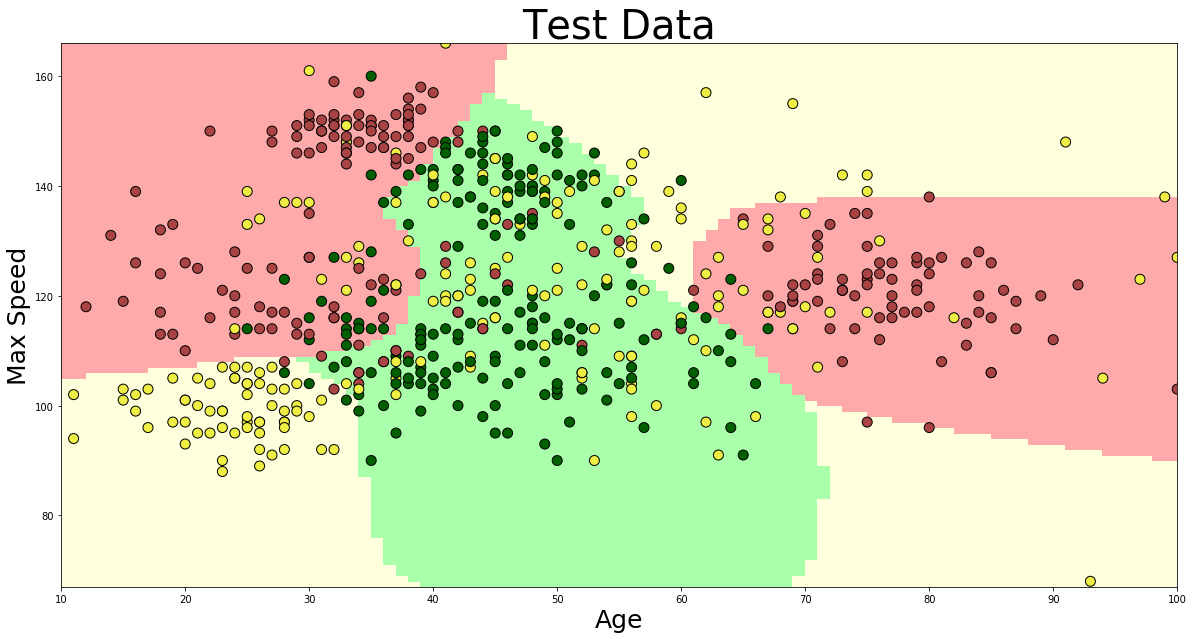

In [77]:
plot_prediction(model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data",
                fname='nn-reg.png')

### Decision boundaries look really smooth, though
Let's see how well we are doing for more dimensions with this model

## Almost all real-life scenarios have many more than 2 inputs
* With more than 2 input features plotting decision boundaries does not make much sense any more
* From now on we work with 3 features and only rely on accuracy measures

In [67]:
dropout = 0.6
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(100, name='hidden1', input_dim=3))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(dropout))

model.add(tf.keras.layers.Dense(100, name='hidden2'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(dropout))

model.add(tf.keras.layers.Dense(num_categories, name='softmax', activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 100)               400       
_________________________________________________________________
batch_normalization_16 (Batc (None, 100)               400       
_________________________________________________________________
activation_16 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 100)               0         
_________________________________________________________________
hidden2 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_17 (Batc (None, 100)               400       
_________________________________________________________________
activation_17 (Activation)   (None, 100)               0         
__________

In [68]:
BATCH_SIZE=1000
EPOCHS = 2000

!rm -rf ./tf_log
# %time model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[tb_callback])
%time model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

Train on 720 samples, validate on 180 samples
Epoch 1/2000
720/720 [==============================] - 1s 2ms/step - loss: 1.6506 - acc: 0.3208 - val_loss: 6.7873 - val_acc: 0.3222
Epoch 2/2000
720/720 [==============================] - 0s 17us/step - loss: 1.6160 - acc: 0.3250 - val_loss: 6.0536 - val_acc: 0.4167
Epoch 3/2000
720/720 [==============================] - 0s 17us/step - loss: 1.5476 - acc: 0.3528 - val_loss: 5.9221 - val_acc: 0.3778
Epoch 4/2000
720/720 [==============================] - 0s 18us/step - loss: 1.5468 - acc: 0.3417 - val_loss: 6.1811 - val_acc: 0.3722
Epoch 5/2000
720/720 [==============================] - 0s 29us/step - loss: 1.4926 - acc: 0.3486 - val_loss: 6.6160 - val_acc: 0.3500
Epoch 6/2000
720/720 [==============================] - 0s 19us/step - loss: 1.4554 - acc: 0.3625 - val_loss: 7.0923 - val_acc: 0.3333
Epoch 7/2000
720/720 [==============================] - 0s 33us/step - loss: 1.3620 - acc: 0.3944 - val_loss: 7.5981 - val_acc: 0.3278
Epoch 8/20

Epoch 61/2000
720/720 [==============================] - 0s 46us/step - loss: 0.9415 - acc: 0.5931 - val_loss: 2.7796 - val_acc: 0.4056
Epoch 62/2000
720/720 [==============================] - 0s 47us/step - loss: 0.9160 - acc: 0.6236 - val_loss: 2.7281 - val_acc: 0.4056
Epoch 63/2000
720/720 [==============================] - 0s 39us/step - loss: 0.8522 - acc: 0.6208 - val_loss: 2.6719 - val_acc: 0.4056
Epoch 64/2000
720/720 [==============================] - 0s 46us/step - loss: 0.9256 - acc: 0.6139 - val_loss: 2.6162 - val_acc: 0.4000
Epoch 65/2000
720/720 [==============================] - 0s 43us/step - loss: 0.9267 - acc: 0.6097 - val_loss: 2.5673 - val_acc: 0.4000
Epoch 66/2000
720/720 [==============================] - 0s 36us/step - loss: 0.9305 - acc: 0.5986 - val_loss: 2.5191 - val_acc: 0.4000
Epoch 67/2000
720/720 [==============================] - 0s 49us/step - loss: 0.9009 - acc: 0.6000 - val_loss: 2.4777 - val_acc: 0.4056
Epoch 68/2000
720/720 [=========================

Epoch 122/2000
720/720 [==============================] - 0s 21us/step - loss: 0.7516 - acc: 0.6806 - val_loss: 1.3924 - val_acc: 0.5056
Epoch 123/2000
720/720 [==============================] - 0s 17us/step - loss: 0.8326 - acc: 0.6681 - val_loss: 1.3802 - val_acc: 0.5222
Epoch 124/2000
720/720 [==============================] - 0s 21us/step - loss: 0.8341 - acc: 0.6639 - val_loss: 1.3682 - val_acc: 0.5222
Epoch 125/2000
720/720 [==============================] - 0s 21us/step - loss: 0.8060 - acc: 0.6514 - val_loss: 1.3564 - val_acc: 0.5222
Epoch 126/2000
720/720 [==============================] - 0s 22us/step - loss: 0.8301 - acc: 0.6639 - val_loss: 1.3442 - val_acc: 0.5222
Epoch 127/2000
720/720 [==============================] - 0s 18us/step - loss: 0.8155 - acc: 0.6458 - val_loss: 1.3325 - val_acc: 0.5222
Epoch 128/2000
720/720 [==============================] - 0s 29us/step - loss: 0.7777 - acc: 0.6750 - val_loss: 1.3217 - val_acc: 0.5222
Epoch 129/2000
720/720 [=================

Epoch 182/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7641 - acc: 0.6764 - val_loss: 0.8923 - val_acc: 0.6056
Epoch 183/2000
720/720 [==============================] - 0s 15us/step - loss: 0.7719 - acc: 0.6667 - val_loss: 0.8872 - val_acc: 0.6111
Epoch 184/2000
720/720 [==============================] - 0s 21us/step - loss: 0.7811 - acc: 0.6764 - val_loss: 0.8815 - val_acc: 0.6167
Epoch 185/2000
720/720 [==============================] - 0s 21us/step - loss: 0.7523 - acc: 0.6986 - val_loss: 0.8758 - val_acc: 0.6167
Epoch 186/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7426 - acc: 0.6861 - val_loss: 0.8715 - val_acc: 0.6222
Epoch 187/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7219 - acc: 0.6972 - val_loss: 0.8676 - val_acc: 0.6222
Epoch 188/2000
720/720 [==============================] - 0s 17us/step - loss: 0.7574 - acc: 0.6903 - val_loss: 0.8638 - val_acc: 0.6167
Epoch 189/2000
720/720 [=================

Epoch 242/2000
720/720 [==============================] - 0s 17us/step - loss: 0.7456 - acc: 0.6917 - val_loss: 0.6735 - val_acc: 0.7444
Epoch 243/2000
720/720 [==============================] - 0s 17us/step - loss: 0.7675 - acc: 0.6736 - val_loss: 0.6706 - val_acc: 0.7444
Epoch 244/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7213 - acc: 0.6958 - val_loss: 0.6687 - val_acc: 0.7444
Epoch 245/2000
720/720 [==============================] - 0s 21us/step - loss: 0.7230 - acc: 0.6972 - val_loss: 0.6662 - val_acc: 0.7444
Epoch 246/2000
720/720 [==============================] - 0s 17us/step - loss: 0.7171 - acc: 0.7069 - val_loss: 0.6635 - val_acc: 0.7444
Epoch 247/2000
720/720 [==============================] - 0s 33us/step - loss: 0.7263 - acc: 0.7125 - val_loss: 0.6609 - val_acc: 0.7500
Epoch 248/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7374 - acc: 0.7014 - val_loss: 0.6584 - val_acc: 0.7444
Epoch 249/2000
720/720 [=================

Epoch 302/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7169 - acc: 0.7167 - val_loss: 0.6093 - val_acc: 0.7778
Epoch 303/2000
720/720 [==============================] - 0s 15us/step - loss: 0.6957 - acc: 0.7264 - val_loss: 0.6078 - val_acc: 0.7722
Epoch 304/2000
720/720 [==============================] - 0s 21us/step - loss: 0.7341 - acc: 0.7083 - val_loss: 0.6068 - val_acc: 0.7778
Epoch 305/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7037 - acc: 0.7264 - val_loss: 0.6058 - val_acc: 0.7722
Epoch 306/2000
720/720 [==============================] - 0s 18us/step - loss: 0.7192 - acc: 0.7236 - val_loss: 0.6051 - val_acc: 0.7722
Epoch 307/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6811 - acc: 0.7111 - val_loss: 0.6044 - val_acc: 0.7778
Epoch 308/2000
720/720 [==============================] - 0s 19us/step - loss: 0.7120 - acc: 0.6931 - val_loss: 0.6039 - val_acc: 0.7778
Epoch 309/2000
720/720 [=================

Epoch 362/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6960 - acc: 0.7153 - val_loss: 0.5757 - val_acc: 0.8056
Epoch 363/2000
720/720 [==============================] - 0s 17us/step - loss: 0.6826 - acc: 0.7319 - val_loss: 0.5753 - val_acc: 0.8056
Epoch 364/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6956 - acc: 0.7292 - val_loss: 0.5749 - val_acc: 0.8111
Epoch 365/2000
720/720 [==============================] - 0s 22us/step - loss: 0.7043 - acc: 0.7264 - val_loss: 0.5746 - val_acc: 0.8111
Epoch 366/2000
720/720 [==============================] - 0s 19us/step - loss: 0.6905 - acc: 0.7222 - val_loss: 0.5745 - val_acc: 0.8111
Epoch 367/2000
720/720 [==============================] - 0s 17us/step - loss: 0.7001 - acc: 0.7028 - val_loss: 0.5742 - val_acc: 0.8111
Epoch 368/2000
720/720 [==============================] - 0s 21us/step - loss: 0.6939 - acc: 0.7347 - val_loss: 0.5739 - val_acc: 0.8111
Epoch 369/2000
720/720 [=================

Epoch 422/2000
720/720 [==============================] - 0s 21us/step - loss: 0.6772 - acc: 0.7375 - val_loss: 0.5636 - val_acc: 0.7833
Epoch 423/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6781 - acc: 0.7403 - val_loss: 0.5631 - val_acc: 0.7889
Epoch 424/2000
720/720 [==============================] - 0s 19us/step - loss: 0.6671 - acc: 0.7347 - val_loss: 0.5626 - val_acc: 0.7944
Epoch 425/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6719 - acc: 0.7250 - val_loss: 0.5621 - val_acc: 0.7944
Epoch 426/2000
720/720 [==============================] - 0s 19us/step - loss: 0.6455 - acc: 0.7306 - val_loss: 0.5613 - val_acc: 0.7944
Epoch 427/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6605 - acc: 0.7347 - val_loss: 0.5606 - val_acc: 0.8000
Epoch 428/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6491 - acc: 0.7556 - val_loss: 0.5603 - val_acc: 0.7944
Epoch 429/2000
720/720 [=================

Epoch 482/2000
720/720 [==============================] - 0s 21us/step - loss: 0.7017 - acc: 0.7222 - val_loss: 0.5597 - val_acc: 0.7889
Epoch 483/2000
720/720 [==============================] - 0s 19us/step - loss: 0.6766 - acc: 0.7250 - val_loss: 0.5604 - val_acc: 0.7833
Epoch 484/2000
720/720 [==============================] - 0s 25us/step - loss: 0.6632 - acc: 0.7403 - val_loss: 0.5610 - val_acc: 0.7833
Epoch 485/2000
720/720 [==============================] - 0s 35us/step - loss: 0.6871 - acc: 0.7333 - val_loss: 0.5612 - val_acc: 0.7833
Epoch 486/2000
720/720 [==============================] - 0s 21us/step - loss: 0.6488 - acc: 0.7403 - val_loss: 0.5617 - val_acc: 0.7833
Epoch 487/2000
720/720 [==============================] - 0s 24us/step - loss: 0.6846 - acc: 0.7194 - val_loss: 0.5617 - val_acc: 0.7889
Epoch 488/2000
720/720 [==============================] - 0s 24us/step - loss: 0.6688 - acc: 0.7194 - val_loss: 0.5620 - val_acc: 0.7778
Epoch 489/2000
720/720 [=================

Epoch 542/2000
720/720 [==============================] - 0s 21us/step - loss: 0.6665 - acc: 0.7417 - val_loss: 0.5667 - val_acc: 0.7556
Epoch 543/2000
720/720 [==============================] - 0s 21us/step - loss: 0.6797 - acc: 0.7306 - val_loss: 0.5678 - val_acc: 0.7556
Epoch 544/2000
720/720 [==============================] - 0s 26us/step - loss: 0.6324 - acc: 0.7528 - val_loss: 0.5687 - val_acc: 0.7556
Epoch 545/2000
720/720 [==============================] - 0s 21us/step - loss: 0.6602 - acc: 0.7431 - val_loss: 0.5694 - val_acc: 0.7500
Epoch 546/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6583 - acc: 0.7431 - val_loss: 0.5700 - val_acc: 0.7500
Epoch 547/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6534 - acc: 0.7389 - val_loss: 0.5706 - val_acc: 0.7500
Epoch 548/2000
720/720 [==============================] - 0s 19us/step - loss: 0.6419 - acc: 0.7472 - val_loss: 0.5711 - val_acc: 0.7500
Epoch 549/2000
720/720 [=================

Epoch 602/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6665 - acc: 0.7500 - val_loss: 0.5604 - val_acc: 0.7667
Epoch 603/2000
720/720 [==============================] - 0s 24us/step - loss: 0.6399 - acc: 0.7722 - val_loss: 0.5608 - val_acc: 0.7667
Epoch 604/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6324 - acc: 0.7528 - val_loss: 0.5616 - val_acc: 0.7722
Epoch 605/2000
720/720 [==============================] - 0s 25us/step - loss: 0.6316 - acc: 0.7639 - val_loss: 0.5620 - val_acc: 0.7722
Epoch 606/2000
720/720 [==============================] - 0s 31us/step - loss: 0.6367 - acc: 0.7500 - val_loss: 0.5623 - val_acc: 0.7667
Epoch 607/2000
720/720 [==============================] - 0s 24us/step - loss: 0.6742 - acc: 0.7458 - val_loss: 0.5625 - val_acc: 0.7667
Epoch 608/2000
720/720 [==============================] - 0s 19us/step - loss: 0.6686 - acc: 0.7486 - val_loss: 0.5632 - val_acc: 0.7611
Epoch 609/2000
720/720 [=================

Epoch 662/2000
720/720 [==============================] - 0s 24us/step - loss: 0.6710 - acc: 0.7389 - val_loss: 0.5772 - val_acc: 0.7333
Epoch 663/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6561 - acc: 0.7306 - val_loss: 0.5762 - val_acc: 0.7333
Epoch 664/2000
720/720 [==============================] - 0s 21us/step - loss: 0.6443 - acc: 0.7569 - val_loss: 0.5750 - val_acc: 0.7444
Epoch 665/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6411 - acc: 0.7542 - val_loss: 0.5737 - val_acc: 0.7444
Epoch 666/2000
720/720 [==============================] - 0s 21us/step - loss: 0.6086 - acc: 0.7569 - val_loss: 0.5729 - val_acc: 0.7444
Epoch 667/2000
720/720 [==============================] - 0s 25us/step - loss: 0.6342 - acc: 0.7528 - val_loss: 0.5719 - val_acc: 0.7444
Epoch 668/2000
720/720 [==============================] - 0s 25us/step - loss: 0.6486 - acc: 0.7514 - val_loss: 0.5706 - val_acc: 0.7500
Epoch 669/2000
720/720 [=================

Epoch 722/2000
720/720 [==============================] - 0s 21us/step - loss: 0.6300 - acc: 0.7625 - val_loss: 0.5560 - val_acc: 0.7667
Epoch 723/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6571 - acc: 0.7583 - val_loss: 0.5572 - val_acc: 0.7611
Epoch 724/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6411 - acc: 0.7458 - val_loss: 0.5585 - val_acc: 0.7611
Epoch 725/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6212 - acc: 0.7667 - val_loss: 0.5597 - val_acc: 0.7611
Epoch 726/2000
720/720 [==============================] - 0s 19us/step - loss: 0.6214 - acc: 0.7486 - val_loss: 0.5611 - val_acc: 0.7667
Epoch 727/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6324 - acc: 0.7417 - val_loss: 0.5627 - val_acc: 0.7667
Epoch 728/2000
720/720 [==============================] - 0s 19us/step - loss: 0.6682 - acc: 0.7444 - val_loss: 0.5640 - val_acc: 0.7611
Epoch 729/2000
720/720 [=================

Epoch 782/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6212 - acc: 0.7486 - val_loss: 0.5615 - val_acc: 0.7611
Epoch 783/2000
720/720 [==============================] - 0s 19us/step - loss: 0.6315 - acc: 0.7431 - val_loss: 0.5610 - val_acc: 0.7667
Epoch 784/2000
720/720 [==============================] - 0s 19us/step - loss: 0.6177 - acc: 0.7583 - val_loss: 0.5607 - val_acc: 0.7667
Epoch 785/2000
720/720 [==============================] - 0s 21us/step - loss: 0.6655 - acc: 0.7597 - val_loss: 0.5613 - val_acc: 0.7667
Epoch 786/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6414 - acc: 0.7611 - val_loss: 0.5617 - val_acc: 0.7667
Epoch 787/2000
720/720 [==============================] - 0s 31us/step - loss: 0.6300 - acc: 0.7708 - val_loss: 0.5621 - val_acc: 0.7667
Epoch 788/2000
720/720 [==============================] - 0s 21us/step - loss: 0.6372 - acc: 0.7514 - val_loss: 0.5625 - val_acc: 0.7667
Epoch 789/2000
720/720 [=================

Epoch 842/2000
720/720 [==============================] - 0s 21us/step - loss: 0.6337 - acc: 0.7472 - val_loss: 0.5512 - val_acc: 0.7611
Epoch 843/2000
720/720 [==============================] - 0s 33us/step - loss: 0.6358 - acc: 0.7583 - val_loss: 0.5510 - val_acc: 0.7611
Epoch 844/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5985 - acc: 0.7722 - val_loss: 0.5506 - val_acc: 0.7611
Epoch 845/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6187 - acc: 0.7681 - val_loss: 0.5502 - val_acc: 0.7611
Epoch 846/2000
720/720 [==============================] - 0s 17us/step - loss: 0.6454 - acc: 0.7472 - val_loss: 0.5498 - val_acc: 0.7667
Epoch 847/2000
720/720 [==============================] - 0s 21us/step - loss: 0.6212 - acc: 0.7583 - val_loss: 0.5492 - val_acc: 0.7778
Epoch 848/2000
720/720 [==============================] - 0s 19us/step - loss: 0.6329 - acc: 0.7458 - val_loss: 0.5485 - val_acc: 0.7778
Epoch 849/2000
720/720 [=================

Epoch 902/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6124 - acc: 0.7681 - val_loss: 0.5416 - val_acc: 0.7889
Epoch 903/2000
720/720 [==============================] - 0s 19us/step - loss: 0.6309 - acc: 0.7667 - val_loss: 0.5419 - val_acc: 0.7889
Epoch 904/2000
720/720 [==============================] - 0s 17us/step - loss: 0.6146 - acc: 0.7625 - val_loss: 0.5431 - val_acc: 0.7889
Epoch 905/2000
720/720 [==============================] - 0s 19us/step - loss: 0.5921 - acc: 0.7847 - val_loss: 0.5442 - val_acc: 0.7889
Epoch 906/2000
720/720 [==============================] - 0s 32us/step - loss: 0.6057 - acc: 0.7528 - val_loss: 0.5457 - val_acc: 0.7833
Epoch 907/2000
720/720 [==============================] - 0s 21us/step - loss: 0.6253 - acc: 0.7653 - val_loss: 0.5467 - val_acc: 0.7833
Epoch 908/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6214 - acc: 0.7486 - val_loss: 0.5475 - val_acc: 0.7833
Epoch 909/2000
720/720 [=================

Epoch 962/2000
720/720 [==============================] - 0s 19us/step - loss: 0.6150 - acc: 0.7667 - val_loss: 0.5387 - val_acc: 0.7778
Epoch 963/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6188 - acc: 0.7625 - val_loss: 0.5375 - val_acc: 0.7833
Epoch 964/2000
720/720 [==============================] - 0s 17us/step - loss: 0.6321 - acc: 0.7500 - val_loss: 0.5366 - val_acc: 0.7833
Epoch 965/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6179 - acc: 0.7597 - val_loss: 0.5357 - val_acc: 0.7778
Epoch 966/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6290 - acc: 0.7500 - val_loss: 0.5353 - val_acc: 0.7778
Epoch 967/2000
720/720 [==============================] - 0s 19us/step - loss: 0.6309 - acc: 0.7625 - val_loss: 0.5351 - val_acc: 0.7778
Epoch 968/2000
720/720 [==============================] - 0s 21us/step - loss: 0.6402 - acc: 0.7708 - val_loss: 0.5353 - val_acc: 0.7778
Epoch 969/2000
720/720 [=================

Epoch 1022/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5979 - acc: 0.7736 - val_loss: 0.5369 - val_acc: 0.7667
Epoch 1023/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6077 - acc: 0.7542 - val_loss: 0.5365 - val_acc: 0.7667
Epoch 1024/2000
720/720 [==============================] - 0s 31us/step - loss: 0.6055 - acc: 0.7694 - val_loss: 0.5363 - val_acc: 0.7667
Epoch 1025/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5951 - acc: 0.7639 - val_loss: 0.5355 - val_acc: 0.7667
Epoch 1026/2000
720/720 [==============================] - 0s 21us/step - loss: 0.6474 - acc: 0.7375 - val_loss: 0.5353 - val_acc: 0.7667
Epoch 1027/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5784 - acc: 0.7861 - val_loss: 0.5352 - val_acc: 0.7667
Epoch 1028/2000
720/720 [==============================] - 0s 21us/step - loss: 0.6203 - acc: 0.7750 - val_loss: 0.5352 - val_acc: 0.7722
Epoch 1029/2000
720/720 [=========

Epoch 1082/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5883 - acc: 0.7722 - val_loss: 0.5283 - val_acc: 0.8000
Epoch 1083/2000
720/720 [==============================] - 0s 21us/step - loss: 0.6188 - acc: 0.7667 - val_loss: 0.5285 - val_acc: 0.8000
Epoch 1084/2000
720/720 [==============================] - 0s 15us/step - loss: 0.6024 - acc: 0.7611 - val_loss: 0.5282 - val_acc: 0.8000
Epoch 1085/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6076 - acc: 0.7569 - val_loss: 0.5278 - val_acc: 0.8000
Epoch 1086/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6038 - acc: 0.7667 - val_loss: 0.5275 - val_acc: 0.8000
Epoch 1087/2000
720/720 [==============================] - 0s 21us/step - loss: 0.6100 - acc: 0.7736 - val_loss: 0.5273 - val_acc: 0.7944
Epoch 1088/2000
720/720 [==============================] - 0s 24us/step - loss: 0.5760 - acc: 0.7764 - val_loss: 0.5271 - val_acc: 0.7944
Epoch 1089/2000
720/720 [=========

Epoch 1142/2000
720/720 [==============================] - 0s 18us/step - loss: 0.6085 - acc: 0.7653 - val_loss: 0.5313 - val_acc: 0.7778
Epoch 1143/2000
720/720 [==============================] - 0s 19us/step - loss: 0.6005 - acc: 0.7764 - val_loss: 0.5296 - val_acc: 0.7778
Epoch 1144/2000
720/720 [==============================] - 0s 17us/step - loss: 0.5803 - acc: 0.7931 - val_loss: 0.5283 - val_acc: 0.7833
Epoch 1145/2000
720/720 [==============================] - 0s 21us/step - loss: 0.5934 - acc: 0.7583 - val_loss: 0.5275 - val_acc: 0.7833
Epoch 1146/2000
720/720 [==============================] - 0s 35us/step - loss: 0.5734 - acc: 0.7778 - val_loss: 0.5268 - val_acc: 0.7833
Epoch 1147/2000
720/720 [==============================] - 0s 19us/step - loss: 0.6108 - acc: 0.7625 - val_loss: 0.5261 - val_acc: 0.7944
Epoch 1148/2000
720/720 [==============================] - 0s 17us/step - loss: 0.5929 - acc: 0.7736 - val_loss: 0.5258 - val_acc: 0.7944
Epoch 1149/2000
720/720 [=========

Epoch 1202/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5912 - acc: 0.7889 - val_loss: 0.5231 - val_acc: 0.8111
Epoch 1203/2000
720/720 [==============================] - 0s 19us/step - loss: 0.5996 - acc: 0.7750 - val_loss: 0.5224 - val_acc: 0.8111
Epoch 1204/2000
720/720 [==============================] - 0s 21us/step - loss: 0.5866 - acc: 0.7764 - val_loss: 0.5219 - val_acc: 0.8111
Epoch 1205/2000
720/720 [==============================] - 0s 32us/step - loss: 0.5824 - acc: 0.7778 - val_loss: 0.5214 - val_acc: 0.8111
Epoch 1206/2000
720/720 [==============================] - 0s 21us/step - loss: 0.5799 - acc: 0.7875 - val_loss: 0.5213 - val_acc: 0.8222
Epoch 1207/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6035 - acc: 0.7806 - val_loss: 0.5216 - val_acc: 0.8222
Epoch 1208/2000
720/720 [==============================] - 0s 28us/step - loss: 0.5802 - acc: 0.7750 - val_loss: 0.5218 - val_acc: 0.8167
Epoch 1209/2000
720/720 [=========

Epoch 1262/2000
720/720 [==============================] - 0s 24us/step - loss: 0.5716 - acc: 0.7931 - val_loss: 0.5250 - val_acc: 0.7778
Epoch 1263/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5994 - acc: 0.7583 - val_loss: 0.5252 - val_acc: 0.7778
Epoch 1264/2000
720/720 [==============================] - 0s 32us/step - loss: 0.5693 - acc: 0.7819 - val_loss: 0.5255 - val_acc: 0.7833
Epoch 1265/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5948 - acc: 0.7639 - val_loss: 0.5262 - val_acc: 0.7833
Epoch 1266/2000
720/720 [==============================] - 0s 22us/step - loss: 0.5622 - acc: 0.7931 - val_loss: 0.5266 - val_acc: 0.7833
Epoch 1267/2000
720/720 [==============================] - 0s 17us/step - loss: 0.6211 - acc: 0.7667 - val_loss: 0.5273 - val_acc: 0.7889
Epoch 1268/2000
720/720 [==============================] - 0s 19us/step - loss: 0.5813 - acc: 0.7778 - val_loss: 0.5278 - val_acc: 0.7833
Epoch 1269/2000
720/720 [=========

Epoch 1322/2000
720/720 [==============================] - 0s 21us/step - loss: 0.5682 - acc: 0.7847 - val_loss: 0.5212 - val_acc: 0.8000
Epoch 1323/2000
720/720 [==============================] - 0s 17us/step - loss: 0.6047 - acc: 0.7667 - val_loss: 0.5219 - val_acc: 0.8000
Epoch 1324/2000
720/720 [==============================] - 0s 17us/step - loss: 0.6063 - acc: 0.7597 - val_loss: 0.5225 - val_acc: 0.8000
Epoch 1325/2000
720/720 [==============================] - 0s 17us/step - loss: 0.5989 - acc: 0.7708 - val_loss: 0.5227 - val_acc: 0.7944
Epoch 1326/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5892 - acc: 0.7833 - val_loss: 0.5235 - val_acc: 0.7944
Epoch 1327/2000
720/720 [==============================] - 0s 17us/step - loss: 0.6041 - acc: 0.7681 - val_loss: 0.5244 - val_acc: 0.7944
Epoch 1328/2000
720/720 [==============================] - 0s 19us/step - loss: 0.5687 - acc: 0.7764 - val_loss: 0.5253 - val_acc: 0.7944
Epoch 1329/2000
720/720 [=========

Epoch 1382/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5523 - acc: 0.7875 - val_loss: 0.5484 - val_acc: 0.7611
Epoch 1383/2000
720/720 [==============================] - 0s 17us/step - loss: 0.5967 - acc: 0.7736 - val_loss: 0.5461 - val_acc: 0.7667
Epoch 1384/2000
720/720 [==============================] - 0s 19us/step - loss: 0.6007 - acc: 0.7625 - val_loss: 0.5434 - val_acc: 0.7667
Epoch 1385/2000
720/720 [==============================] - 0s 17us/step - loss: 0.5863 - acc: 0.7722 - val_loss: 0.5413 - val_acc: 0.7722
Epoch 1386/2000
720/720 [==============================] - 0s 21us/step - loss: 0.5610 - acc: 0.7792 - val_loss: 0.5392 - val_acc: 0.7778
Epoch 1387/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5791 - acc: 0.7708 - val_loss: 0.5378 - val_acc: 0.7833
Epoch 1388/2000
720/720 [==============================] - 0s 19us/step - loss: 0.5590 - acc: 0.7861 - val_loss: 0.5368 - val_acc: 0.7833
Epoch 1389/2000
720/720 [=========

Epoch 1442/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5553 - acc: 0.7806 - val_loss: 0.5366 - val_acc: 0.7611
Epoch 1443/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5941 - acc: 0.7736 - val_loss: 0.5364 - val_acc: 0.7667
Epoch 1444/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5655 - acc: 0.7847 - val_loss: 0.5362 - val_acc: 0.7611
Epoch 1445/2000
720/720 [==============================] - 0s 21us/step - loss: 0.5674 - acc: 0.7889 - val_loss: 0.5362 - val_acc: 0.7611
Epoch 1446/2000
720/720 [==============================] - 0s 19us/step - loss: 0.5924 - acc: 0.7847 - val_loss: 0.5365 - val_acc: 0.7611
Epoch 1447/2000
720/720 [==============================] - 0s 21us/step - loss: 0.5549 - acc: 0.7972 - val_loss: 0.5372 - val_acc: 0.7667
Epoch 1448/2000
720/720 [==============================] - 0s 32us/step - loss: 0.5728 - acc: 0.7847 - val_loss: 0.5379 - val_acc: 0.7667
Epoch 1449/2000
720/720 [=========

Epoch 1502/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5611 - acc: 0.7778 - val_loss: 0.5429 - val_acc: 0.8000
Epoch 1503/2000
720/720 [==============================] - 0s 19us/step - loss: 0.5551 - acc: 0.7750 - val_loss: 0.5424 - val_acc: 0.8000
Epoch 1504/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5776 - acc: 0.7722 - val_loss: 0.5417 - val_acc: 0.8000
Epoch 1505/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5606 - acc: 0.7861 - val_loss: 0.5415 - val_acc: 0.8000
Epoch 1506/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5583 - acc: 0.7944 - val_loss: 0.5412 - val_acc: 0.8000
Epoch 1507/2000
720/720 [==============================] - 0s 29us/step - loss: 0.5653 - acc: 0.7903 - val_loss: 0.5409 - val_acc: 0.7944
Epoch 1508/2000
720/720 [==============================] - 0s 22us/step - loss: 0.5708 - acc: 0.7861 - val_loss: 0.5408 - val_acc: 0.7944
Epoch 1509/2000
720/720 [=========

Epoch 1562/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5775 - acc: 0.7903 - val_loss: 0.5633 - val_acc: 0.7556
Epoch 1563/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5611 - acc: 0.7736 - val_loss: 0.5614 - val_acc: 0.7611
Epoch 1564/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5633 - acc: 0.7917 - val_loss: 0.5589 - val_acc: 0.7611
Epoch 1565/2000
720/720 [==============================] - 0s 31us/step - loss: 0.5544 - acc: 0.7819 - val_loss: 0.5573 - val_acc: 0.7611
Epoch 1566/2000
720/720 [==============================] - 0s 21us/step - loss: 0.5729 - acc: 0.7736 - val_loss: 0.5563 - val_acc: 0.7611
Epoch 1567/2000
720/720 [==============================] - 0s 17us/step - loss: 0.5765 - acc: 0.7972 - val_loss: 0.5553 - val_acc: 0.7667
Epoch 1568/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5621 - acc: 0.7931 - val_loss: 0.5536 - val_acc: 0.7667
Epoch 1569/2000
720/720 [=========

Epoch 1622/2000
720/720 [==============================] - 0s 21us/step - loss: 0.5674 - acc: 0.7819 - val_loss: 0.5631 - val_acc: 0.7556
Epoch 1623/2000
720/720 [==============================] - 0s 17us/step - loss: 0.5921 - acc: 0.7639 - val_loss: 0.5602 - val_acc: 0.7667
Epoch 1624/2000
720/720 [==============================] - 0s 17us/step - loss: 0.5705 - acc: 0.7861 - val_loss: 0.5585 - val_acc: 0.7667
Epoch 1625/2000
720/720 [==============================] - 0s 17us/step - loss: 0.5592 - acc: 0.7792 - val_loss: 0.5564 - val_acc: 0.7667
Epoch 1626/2000
720/720 [==============================] - 0s 15us/step - loss: 0.5472 - acc: 0.8028 - val_loss: 0.5535 - val_acc: 0.7722
Epoch 1627/2000
720/720 [==============================] - 0s 17us/step - loss: 0.5753 - acc: 0.7819 - val_loss: 0.5509 - val_acc: 0.7722
Epoch 1628/2000
720/720 [==============================] - 0s 19us/step - loss: 0.5610 - acc: 0.7875 - val_loss: 0.5489 - val_acc: 0.7611
Epoch 1629/2000
720/720 [=========

Epoch 1682/2000
720/720 [==============================] - 0s 26us/step - loss: 0.5656 - acc: 0.7750 - val_loss: 0.5426 - val_acc: 0.8111
Epoch 1683/2000
720/720 [==============================] - 0s 24us/step - loss: 0.5572 - acc: 0.7847 - val_loss: 0.5418 - val_acc: 0.8056
Epoch 1684/2000
720/720 [==============================] - 0s 24us/step - loss: 0.5652 - acc: 0.7875 - val_loss: 0.5409 - val_acc: 0.8056
Epoch 1685/2000
720/720 [==============================] - 0s 25us/step - loss: 0.5416 - acc: 0.7958 - val_loss: 0.5396 - val_acc: 0.8000
Epoch 1686/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5476 - acc: 0.7972 - val_loss: 0.5381 - val_acc: 0.8111
Epoch 1687/2000
720/720 [==============================] - 0s 21us/step - loss: 0.5950 - acc: 0.7639 - val_loss: 0.5382 - val_acc: 0.8111
Epoch 1688/2000
720/720 [==============================] - 0s 21us/step - loss: 0.5516 - acc: 0.7986 - val_loss: 0.5384 - val_acc: 0.8111
Epoch 1689/2000
720/720 [=========

Epoch 1742/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5534 - acc: 0.7944 - val_loss: 0.5478 - val_acc: 0.7889
Epoch 1743/2000
720/720 [==============================] - 0s 17us/step - loss: 0.5863 - acc: 0.7639 - val_loss: 0.5464 - val_acc: 0.7889
Epoch 1744/2000
720/720 [==============================] - 0s 17us/step - loss: 0.5670 - acc: 0.7847 - val_loss: 0.5463 - val_acc: 0.7889
Epoch 1745/2000
720/720 [==============================] - 0s 19us/step - loss: 0.5608 - acc: 0.7806 - val_loss: 0.5469 - val_acc: 0.7944
Epoch 1746/2000
720/720 [==============================] - 0s 21us/step - loss: 0.5841 - acc: 0.7708 - val_loss: 0.5475 - val_acc: 0.7944
Epoch 1747/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5779 - acc: 0.7875 - val_loss: 0.5483 - val_acc: 0.7889
Epoch 1748/2000
720/720 [==============================] - 0s 17us/step - loss: 0.5363 - acc: 0.7903 - val_loss: 0.5493 - val_acc: 0.7889
Epoch 1749/2000
720/720 [=========

Epoch 1802/2000
720/720 [==============================] - 0s 22us/step - loss: 0.5544 - acc: 0.7833 - val_loss: 0.5517 - val_acc: 0.7833
Epoch 1803/2000
720/720 [==============================] - 0s 33us/step - loss: 0.5526 - acc: 0.7917 - val_loss: 0.5517 - val_acc: 0.7778
Epoch 1804/2000
720/720 [==============================] - 0s 22us/step - loss: 0.5566 - acc: 0.7875 - val_loss: 0.5510 - val_acc: 0.7722
Epoch 1805/2000
720/720 [==============================] - 0s 19us/step - loss: 0.5646 - acc: 0.7806 - val_loss: 0.5493 - val_acc: 0.7778
Epoch 1806/2000
720/720 [==============================] - 0s 19us/step - loss: 0.5362 - acc: 0.7944 - val_loss: 0.5477 - val_acc: 0.7778
Epoch 1807/2000
720/720 [==============================] - 0s 19us/step - loss: 0.5636 - acc: 0.7806 - val_loss: 0.5471 - val_acc: 0.7722
Epoch 1808/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5592 - acc: 0.7861 - val_loss: 0.5462 - val_acc: 0.7722
Epoch 1809/2000
720/720 [=========

Epoch 1862/2000
720/720 [==============================] - 0s 17us/step - loss: 0.5638 - acc: 0.7778 - val_loss: 0.5377 - val_acc: 0.7833
Epoch 1863/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5594 - acc: 0.7903 - val_loss: 0.5378 - val_acc: 0.7889
Epoch 1864/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5600 - acc: 0.7819 - val_loss: 0.5381 - val_acc: 0.7889
Epoch 1865/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5483 - acc: 0.7819 - val_loss: 0.5381 - val_acc: 0.7833
Epoch 1866/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5569 - acc: 0.7931 - val_loss: 0.5370 - val_acc: 0.7778
Epoch 1867/2000
720/720 [==============================] - 0s 21us/step - loss: 0.5720 - acc: 0.7847 - val_loss: 0.5361 - val_acc: 0.7833
Epoch 1868/2000
720/720 [==============================] - 0s 29us/step - loss: 0.5509 - acc: 0.7986 - val_loss: 0.5361 - val_acc: 0.7778
Epoch 1869/2000
720/720 [=========

Epoch 1922/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5799 - acc: 0.7986 - val_loss: 0.5323 - val_acc: 0.8056
Epoch 1923/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5755 - acc: 0.7792 - val_loss: 0.5312 - val_acc: 0.8056
Epoch 1924/2000
720/720 [==============================] - 0s 17us/step - loss: 0.5266 - acc: 0.8056 - val_loss: 0.5307 - val_acc: 0.8056
Epoch 1925/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5808 - acc: 0.7833 - val_loss: 0.5307 - val_acc: 0.8056
Epoch 1926/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5740 - acc: 0.7597 - val_loss: 0.5307 - val_acc: 0.8056
Epoch 1927/2000
720/720 [==============================] - 0s 21us/step - loss: 0.5549 - acc: 0.7889 - val_loss: 0.5307 - val_acc: 0.8111
Epoch 1928/2000
720/720 [==============================] - 0s 29us/step - loss: 0.5652 - acc: 0.7736 - val_loss: 0.5304 - val_acc: 0.8111
Epoch 1929/2000
720/720 [=========

Epoch 1982/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5223 - acc: 0.8083 - val_loss: 0.5268 - val_acc: 0.7944
Epoch 1983/2000
720/720 [==============================] - 0s 17us/step - loss: 0.5661 - acc: 0.7833 - val_loss: 0.5258 - val_acc: 0.8000
Epoch 1984/2000
720/720 [==============================] - 0s 17us/step - loss: 0.5484 - acc: 0.7931 - val_loss: 0.5247 - val_acc: 0.8000
Epoch 1985/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5569 - acc: 0.7847 - val_loss: 0.5236 - val_acc: 0.8000
Epoch 1986/2000
720/720 [==============================] - 0s 21us/step - loss: 0.5517 - acc: 0.8028 - val_loss: 0.5231 - val_acc: 0.8000
Epoch 1987/2000
720/720 [==============================] - 0s 17us/step - loss: 0.5492 - acc: 0.7944 - val_loss: 0.5227 - val_acc: 0.8056
Epoch 1988/2000
720/720 [==============================] - 0s 18us/step - loss: 0.5503 - acc: 0.7847 - val_loss: 0.5226 - val_acc: 0.8111
Epoch 1989/2000
720/720 [=========

In [69]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
train_loss, train_accuracy

900/900 [==============================] - 0s 7us/step


(0.4815836548805237, 0.8199999928474426)

In [70]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
test_loss, test_accuracy

600/600 [==============================] - 0s 5us/step


(0.5192855596542358, 0.7950000166893005)